# Week 5 - A/B Test with Python

This is the companion Jupyter notebook for Week 5 - A/B Test with Python. In this notebook, we: 
- Retrieve data from the Google Analytics API  
- Perform power analysis to recommend an appropriate sample size  
- Conduct a Student’s t-test to evaluate our hypothesis  
- Conduct a Welch’s t-test to evaluate our hypothesis  
- Compare the performance and assumptions of the two t-tests  

# 1. Import Packages
Other than the statistical package of Pingouin, we will introduce a new package today. Google Analytics Data API. Google has developed the package of `google.analytics.data` to allow easy retrieval of historical reports.
This is the documentation of this package: https://developers.google.com/analytics/devguides/reporting/data/v1/rest

In [ ]:
!pip3 install google.analytics.data
!pip3 install pingouin

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 4.3/4.3 MB 85.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the packages needed.

In [23]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    Filter,
    FilterExpression,
)
import os
import pandas as pd
import json
import scipy.stats as st 
import numpy as np

# 2. An End-to-end A/B Test Example

Following the class notes, we will implement hypothesis testing for an experiment comparing the original website (control) to a variant in which the header bar color was changed (treatment).

## 2.0 Sample Size

Before running an A/B test, it's important to conduct a power analysis to estimate the required sample size. This ensures your experiment is capable of detecting a meaningful effect if one exists. The sample size depends on the following key inputs:

- Baseline performance (e.g., current conversion rate)
- Expected variant performance (e.g., projected improvement)
- Desired power (typically 0.8 or 80%)
- Significance level (alpha) (commonly set at 0.05)

When you're launching a new experiment, you often have limited information about how the variant will perform, so you'll need to make assumptions or use industry benchmarks. However, in a follow-up study—such as refining a previously tested feature—you can use prior results to make a more informed estimate of the expected performance, leading to a more accurate and efficient sample size calculation.

In [56]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Inputs
baseline_rate = 0.5
variant_rate = 0.7
effect_size = proportion_effectsize(baseline_rate, variant_rate)

# Power analysis
analysis = NormalIndPower()
sample_size_per_group = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, alternative='two-sided')

print(f"Required sample size per group: {int(sample_size_per_group)}")


Required sample size per group: 92


We are going to introduce `functions` in python! We talked about functions in Week 3, functions are prewritten blocks of code that can be invoked to carry out a certain set of actions.
We have used many different functions. But how to generate user-defined functions? Through the following three examples, you will get the basics.

1. A function with no input and no return

In [ ]:
def say_hello():
    print("Hello, class!")

say_hello()

Hello, world!


2. A function with one input.

In [2]:
def get_dimensions(dimension):
    print(f"This is a report based on {dimension}!")

get_dimensions("device")
get_dimensions("date")

This is a report based on device!
This is a report based on date!


3. A function with return

In [4]:
def get_metrics(dimension):
    if dimension=="mobile":
        return 234
    else:
        return 0

result = get_metrics("mobile")
print(result)

234


Below is a function ```sample_run_report```. The parameter is the property id, and the dimensions, metrics, and date_ranges can be specified below.

Suppose we have run the A/B test. Now we need to retrieve data from Google Analytics to perform statistical analysis to test our hypothesis. Our hypothesis testing takes three steps:

- Step 1: Get conversion sessions (A submit event has been detected in a session) at a date level.
- Step 2: Get total sessions (total number of sessions) at a date level.
- Step 3: Perform a left join to merge the two datasets and calcualte the ratio of submit.
- Step 4: Get the ratio for treatment condition and control condition.
- Step 5: Run the t-test and interpret the results.

## 2.1 Conversion Report

Google Analytics provides APIs for others to retrieve data in a flexible way. The flexible report generation is based on the definition of **dimensions** and **metrics**.
More information about dimensions and metrics can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema). More information about how to generate reports can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#python_3).

In [37]:
def sample_run_report_conversion(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    #os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'bigquery-419120-14d56b3f70eb.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="campaignName"),Dimension(name="eventName"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2025-01-01", end_date="2025-04-07")],
         dimension_filter=FilterExpression(
            filter=Filter(
                field_name="campaignName",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

## 2.2 Session Report
The report below shows all experimental sessions:

In [39]:
def sample_run_report_session(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'bigquery-419120-14d56b3f70eb.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="customEvent:Branch"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2025-01-01", end_date="2025-04-07")],
          dimension_filter=FilterExpression(
            filter=Filter(
                field_name="customEvent:Branch",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

## 2.3 Data Conversion
The default output is json, which we can transform into a dataframe using the following function **response_to_df**.

In [40]:
def response_to_df(response):
    columns = []
    rows = []
     
    for col in response.dimension_headers:
        columns.append(col.name)
    for col in response.metric_headers:
        columns.append(col.name)
     
    for row_data in response.rows:
        row = []
        for val in row_data.dimension_values:
            row.append(val.value)
        for val in row_data.metric_values:
            row.append(val.value)
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)


## 2.4 Data Collection Pipeline

### 2.4.1 Step 1: Conversion Data
The code below shows the main pipeline of step 1.

In [41]:
response=sample_run_report_conversion(property_id="424145747")
df1=response_to_df(response)
# change the column name from  campaignName to customEvent:Branch
df1.rename(columns={'campaignName': 'customEvent:Branch'}, inplace=True)
# Only look at submit
df1 = df1[df1['eventName'] == 'submit']
df1

,customEvent:Branch,eventName,date,sessions
2,experiment,submit,20250407,5
3,main,submit,20250320,5
5,main,submit,20250407,4
8,main,submit,20250228,3
9,main,submit,20250301,3
14,main,submit,20250227,2
17,experiment,submit,20250307,1
18,experiment,submit,20250310,1
19,experiment,submit,20250311,1
26,main,submit,20250303,1


### 2.4.2 Step 2: Session Data
In Step 2, we retrieve session numbers at each given day for control and treatment.

In [42]:
response=sample_run_report_session(property_id="424145747")
df2=response_to_df(response)
print(df2)

   customEvent:Branch      date sessions
0                main  20250313       36
1                main  20250320       19
2                main  20250312       16
3                main  20250228        9
4                main  20250319        9
5                main  20250316        8
6                main  20250317        8
7          experiment  20250407        6
8                main  20250321        6
9                main  20250407        6
10               main  20250227        5
11               main  20250301        4
12               main  20250326        4
13               main  20250303        3
14               main  20250314        3
15               main  20250318        3
16               main  20250327        3
17               main  20250306        2
18               main  20250311        2
19               main  20250315        2
20               main  20250322        2
21               main  20250324        2
22               main  20250325        2
23              

## 2.5. Hypothesis Testing 

### 2.5.1 Step 3: Merge Data
To combine the two datasets, we used a merge function:

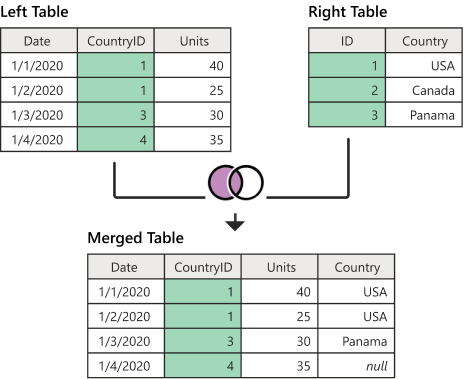

In [ ]:


# the merge function can combine two dataframes based on keywords. A left 
merged_df = pd.merge(df2, df1, on=['date', 'customEvent:Branch'], how='left')

merged_df.fillna(0, inplace=True)


### 2.5.2 Step 4: Calculate the Ratio

In [ ]:
# calculate the ratio between submission sessions and all sessions per day.
merged_df['submit_session_ratio_per_day']=merged_df['sessions_y'].astype(int)/merged_df['sessions_x'].astype(int)

# extract data for control
control = merged_df[merged_df['customEvent:Branch'] == 'main']['submit_session_ratio_per_day']
# extract data for treatment 
treatment =merged_df[merged_df['customEvent:Branch'] == 'experiment']['submit_session_ratio_per_day']

### Step 5: Hypothesis Testing

An independent t-test is used to compare the means of the same group at two different times or under two different conditions. To run statistical tests, we can use the package of ```scipy``` or ```pingouin```.  The independent samples-test comes in two different forms, Student’s and Welch’s. Student's T-test relies on much more restrictive assumptions than the Welch's T-test. Remember that the goal is to determine whether the treatment and control data are drawn from populations with the same mean (the null hypothesis) or different means (the alternative hypothesis). When I say "independent" samples, what I really mean here is that there’s no special relationship between observations in the two samples because a user can either be in treatment or control.

### 2.5.3 T-Test Assuming Equal Variance
This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.



In [57]:
from pingouin import ttest

ttest(treatment,control,correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.03983,35,two-sided,0.00446,"[0.12, 0.61]",1.213965,9.073,0.840252


**More comprehensive results**

In [45]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
results=[]
 # Means
mean_treatment = treatment.mean()
mean_control = control.mean()

# Absolute and percentage difference
abs_diff = mean_treatment - mean_control
pct_diff = (abs_diff / mean_control) * 100

# T-test using pingouin
ttest = pg.ttest(treatment, control, correction=False)
ci_low, ci_high = ttest['CI95%'].values[0]

results.append({
    'Test': "Student's T-Test",
    'Mean Treatment': mean_treatment,
    'Mean Control': mean_control,
    'Abs Diff': abs_diff,
    'Pct Diff (%)': pct_diff,
    'p-value': ttest['p-val'].values[0],
    'CI Lower': ci_low,
    'CI Upper': ci_high
})



### 2.5.4 T-Test Assuming Unequal Variance


The biggest problem with using the Student test in practice is the assumption listed in the previous section: it assumes that both groups have the same standard deviation. This is rarely true in real life: if two samples don’t have the same means, why should we expect them to have the same standard deviation? There’s really no reason to expect this assumption to be true. The figure below illustrated the assumption for the Welch's t-test.

In [47]:
from pingouin import ttest

ttest(treatment,control,correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.967693,7.711707,two-sided,0.085993,"[-0.07, 0.8]",1.213965,1.469,0.840252


**More comprehensive result:**

In [48]:
mean_treatment = treatment.mean()
mean_control = control.mean()

# Absolute and percentage difference
abs_diff = mean_treatment - mean_control
pct_diff = (abs_diff / mean_control) * 100

# T-test using pingouin
ttest = pg.ttest(treatment, control, correction=True)
ci_low, ci_high = ttest['CI95%'].values[0]

results.append({
    'Test': "Felch's T-Test",
    'Mean Treatment': mean_treatment,
    'Mean Control': mean_control,
    'Abs Diff': abs_diff,
    'Pct Diff (%)': pct_diff,
    'p-value': ttest['p-val'].values[0],
    'CI Lower': ci_low,
    'CI Upper': ci_high
})


In [50]:
results_df=pd.DataFrame(results)
results_df

,Test,Mean Treatment,Mean Control,Abs Diff,Pct Diff (%),p-value,CI Lower,CI Upper
0,Student's T-Test,0.479167,0.111948,0.367219,328.026209,0.004460,0.12,0.61
1,Felch's T-Test,0.479167,0.111948,0.367219,328.026209,0.085993,-0.07,0.80


### [Optional] We can further visualize the results

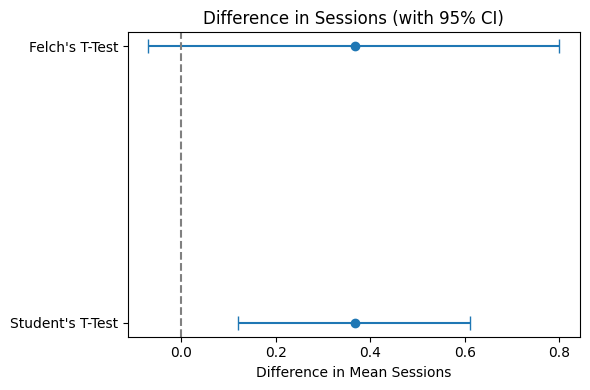

In [52]:
import matplotlib.pyplot as plt

# Vertical version: horizontal error bars
fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(
    x=results_df['Abs Diff'],
    y=results_df['Test'],
    xerr=[results_df['Abs Diff'] - results_df['CI Lower'], results_df['CI Upper'] - results_df['Abs Diff']],
    fmt='o',
    capsize=5,
    linestyle='none'
)

ax.axvline(0, color='gray', linestyle='--')
ax.set_xlabel("Difference in Mean Sessions")
ax.set_title("Difference in Sessions (with 95% CI)")
plt.tight_layout()
plt.show()
